In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")
sys.path.append("../../CompoTree/src")

In [3]:
from gensim.models import KeyedVectors
from fluidvec import create_fluid_keyvec, VocabSet
from matplotlib import pyplot as plt

In [4]:
vs = VocabSet.load()
wvocab = vs.word_vocab

In [5]:
fkv = create_fluid_keyvec("../data/model/fluidvec-char.b.1", "../data/model/fluidvec-compo.b.1")
fkv

device:  cpu
n_neg_sample:  5
device:  cpu
n_neg_sample:  5


<FluidKeyedVectors: 217350 words, 20396 chars, 3504 compos, 100 dimensions>

## Load CLP

In [7]:
import pandas as pd

In [9]:
clp = pd.read_excel("../data/behavioral/Tse-2017-Chinese-lexicon-project.xlsx", sheet_name="Word")

In [79]:
def get_asbc_wfreq(w):
    widx = vs.word_vocab.encode(w)
    if widx >= 0:
        return vs.word_vocab.freq[widx]
    else:
        return 0

def compute_word_to_prefix(w, c1):
    if f"/{c1}." not in fkv:
        return None
    else:
        return fkv.similarity(w, f"/{c1}.")

def compute_word_to_suffix(w, c2):
    if f".{c2}/" not in fkv:
        return None
    else:
        return fkv.similarity(w, f".{c2}/")

def compute_word_to_char(w, ch):
    if f"/{ch}/" not in fkv:
        return None
    else:
        return fkv.similarity(w, f"/{ch}/")
    

In [113]:
subdfr = clp.loc[clp["Word_Trad"].apply(lambda x: x in fkv), ["Word_Trad", "RT", "ST-C1", "ST-C2"]]
subdfr["RTinv"] = -1000 / subdfr["RT"]
subdfr.insert(2, "RTinv", subdfr.pop("RTinv"))
clp.shape, subdfr.shape

((25281, 28), (23459, 5))

In [114]:
sim_scores = subdfr.apply(lambda row: (
    get_asbc_wfreq(row["Word_Trad"]),
    compute_word_to_prefix(row["Word_Trad"], row["Word_Trad"][0]),
    compute_word_to_suffix(row["Word_Trad"], row["Word_Trad"][1]),
    compute_word_to_char(row["Word_Trad"], row["Word_Trad"][0]),
    compute_word_to_char(row["Word_Trad"], row["Word_Trad"][1])
    ), axis=1, result_type="expand")
sim_scores.columns = ["asbc_wfreq", "fkv-c1", "fkv-c2", "fkv-isol.c1", "fkv-isol.c2"]

## Full dataset

In [167]:
print(sim_df.shape)
sim_df.head()

(23459, 11)


,Word_Trad,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-isol.c1,fkv-isol.c2,isHFreq
0,一刀,677.79,-1.475383,-0.43,0.15,1.0,-0.253976,-0.355439,-0.321505,-0.467034,False
1,一口,698.89,-1.430840,-0.77,-0.05,94.0,-0.140936,-0.145381,-0.181668,0.063742,False
2,一分,628.78,-1.590381,-0.43,-0.03,1.0,-0.328547,-0.335653,-0.353718,-0.383980,False
3,一切,560.91,-1.782817,-0.84,-1.28,2554.0,-0.165610,0.072127,-0.216255,-0.340356,True
4,一心,646.34,-1.547173,-0.86,-0.62,123.0,-0.130632,-0.043115,-0.235058,-0.106061,False


In [115]:
sim_df = pd.concat([subdfr, sim_scores], axis=1)
sim_df.corr()

,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-isol.c1,fkv-isol.c2
RT,1.000000,0.988323,-0.054630,0.018890,-0.243922,-0.377672,-0.377077,-0.254446,-0.250090
RTinv,0.988323,1.000000,-0.050267,0.025582,-0.277504,-0.393899,-0.391385,-0.266052,-0.258542
ST-C1,-0.054630,-0.050267,1.000000,0.048098,-0.046693,0.053682,-0.010190,-0.011179,0.020685
ST-C2,0.018890,0.025582,0.048098,1.000000,-0.098375,-0.074212,-0.036378,-0.091154,-0.083535
asbc_wfreq,-0.243922,-0.277504,-0.046693,-0.098375,1.000000,0.282174,0.254313,0.182334,0.158671
fkv-c1,-0.377672,-0.393899,0.053682,-0.074212,0.282174,1.000000,0.615783,0.544651,0.423318
fkv-c2,-0.377077,-0.391385,-0.010190,-0.036378,0.254313,0.615783,1.000000,0.436449,0.521726
fkv-isol.c1,-0.254446,-0.266052,-0.011179,-0.091154,0.182334,0.544651,0.436449,1.000000,0.398952
fkv-isol.c2,-0.250090,-0.258542,0.020685,-0.083535,0.158671,0.423318,0.521726,0.398952,1.000000


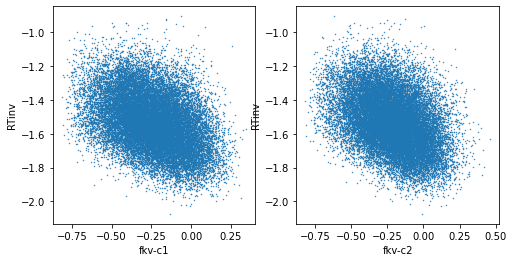

In [168]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
sim_df.plot.scatter("fkv-c1", "RTinv", s=0.2, ax=axes[0])
sim_df.plot.scatter("fkv-c2", "RTinv", s=0.2, ax=axes[1])

## Grouping by frequency

In [159]:
simhf_df = sim_df.loc[sim_df.asbc_wfreq > 150, :]
print(simhf_df.shape)
simhf_df.head()

(4017, 11)


,Word_Trad,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-isol.c1,fkv-isol.c2,isHFreq
3,一切,560.91,-1.782817,-0.84,-1.28,2554.0,-0.165610,0.072127,-0.216255,-0.340356,True
7,一半,576.94,-1.733282,-2.02,0.77,715.0,-0.184805,-0.009384,-0.173939,-0.147929,True
8,一旦,639.57,-1.563551,-1.71,-0.87,1092.0,-0.228571,0.088540,-0.215310,-0.350775,True
9,一生,577.00,-1.733102,-1.17,-0.36,777.0,-0.129093,-0.115314,-0.110845,-0.115496,True
10,一共,729.32,-1.371140,-1.34,0.29,159.0,-0.228311,-0.248210,-0.112503,0.123144,False


In [160]:
simhf_df.corr()

,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-isol.c1,fkv-isol.c2,isHFreq
RT,1.000000,0.990311,-0.083278,-0.022805,-0.232723,-0.102610,-0.081366,0.047541,0.003835,-0.167986
RTinv,0.990311,1.000000,-0.076973,-0.014923,-0.253214,-0.104296,-0.083459,0.039571,-0.001941,-0.175741
ST-C1,-0.083278,-0.076973,1.000000,0.117107,-0.064535,0.289235,-0.060852,0.118544,0.009161,-0.050512
ST-C2,-0.022805,-0.014923,0.117107,1.000000,-0.118016,-0.005231,0.269255,-0.102402,0.051424,-0.063298
asbc_wfreq,-0.232723,-0.253214,-0.064535,-0.118016,1.000000,0.123198,0.099265,0.059886,0.047574,0.232919
fkv-c1,-0.102610,-0.104296,0.289235,-0.005231,0.123198,1.000000,0.146489,0.074008,-0.010016,0.166720
fkv-c2,-0.081366,-0.083459,-0.060852,0.269255,0.099265,0.146489,1.000000,-0.023974,0.059363,0.133152
fkv-isol.c1,0.047541,0.039571,0.118544,-0.102402,0.059886,0.074008,-0.023974,1.000000,0.265707,0.056344
fkv-isol.c2,0.003835,-0.001941,0.009161,0.051424,0.047574,-0.010016,0.059363,0.265707,1.000000,0.040984
isHFreq,-0.167986,-0.175741,-0.050512,-0.063298,0.232919,0.166720,0.133152,0.056344,0.040984,1.000000


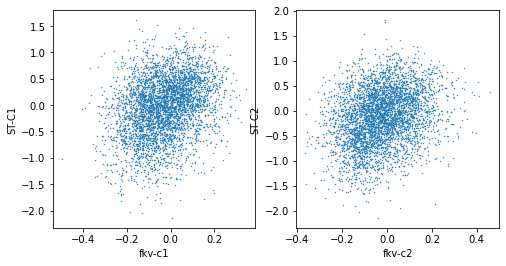

In [169]:
from matplotlib import pyplot as plt
_, axes = plt.subplots(1, 2, figsize=(8, 4))
simhf_df.plot.scatter("fkv-c1", "ST-C1", s=0.2, ax=axes[0])
simhf_df.plot.scatter("fkv-c2", "ST-C2", s=0.2, ax=axes[1])

## Transparency ratings

In [176]:
clp.corr().loc[:, ["ST-C1", "ST-C2"]].drop(["Ntrials", "zRT"], axis=0)

,ST-C1,ST-C2
Acc,0.101676,0.037588
RT,-0.051189,0.029127
RT-SE,-0.062055,-0.011810
RT-SD,-0.033367,0.009497
Stroke-1,0.204220,0.024552
Stroke-2,-0.035342,0.223287
C&B-Subtitle-raw-C1,-0.222926,-0.087451
C&B-Subtitle-raw-C2,0.033582,-0.248204
C&B-Subtitle-CD-C1,-0.312740,-0.089795
C&B-Subtitle-CD-C2,0.024186,-0.361606
